# Path integration

**Author:** Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will show how the position and heading of the animal can be estimated by integrating mechanosensory signals, a process known as path integration.

## Introduction

In the previous tutorials, we have demonstrated how brain-level processes can drive the motor system via _descending control_. _Ascending_ motor signals are a complement to descending information as they convey information, often mechanosensory in nature, back to the brain. Ascending signals are predicted to inform brain-level action selection, motor planning, and sensory contextualization (see [Chen et al., 2023](https://doi.org/10.1038/s41593-023-01281-z)). In this tutorial and the next, we will demonstrate how incorporating ascending motor feedback signals allows us to model behaviors that are critical to the animal's survival and functioning.

Animals, including flies, estimate their own orientation and distance traveled ("odometry") to perform path integration when navigating the world. A superb example of path integration was demonstrated in the desert ant _Cataglyphis fortis_ (see [review by Wolf, 2011](https://doi.org/10.1242/jeb.038570)). While the ant takes an exploratory outbound path in search of a food source, it can return to the nest in a straight line. Furthermore, if the experimenter moves the ant to a different location upon finding the food, the ant still takes the "correct" path back to the nest, but starting from the location where it has been "air dropped" (as shown below). These results show that the ant must be using idiothetic cues, rather than sensory input, to navigate — similar to how sailors used to navigate featureless oceans by "dead reckoning."

<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/path_integration/pathint_schematic.png?raw=true" alt="pathint_schematic.png" width="300"/>
</p>

The fly _Drosophila melanogaster_ also performs path integration, especially when navigating to find food sources (see [Kim & Dickinson, 2017](https://doi.org/10.1016/j.cub.2017.06.026), [Behbahani et al., 2021](https://doi.org/10.1016/j.cub.2021.08.006)). While the source of the idiothetic cues are unknown, they may, in principle, be derived using ascending proprioceptive and tactile signals from the legs and motor system. As a demonstration, we will attempt to estimate the changes in the fly's orientation (shown below in green) and displacement (shown below in purple) based on proprioceptive and tactile information. By integrating these changes over time, we aim to reconstruct the path of the fly in space (right).

<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/path_integration/pathint_integration.png?raw=true" alt="pathint_integration.png" width="600"/>
</p>

## The algorithm

Having hand-waved at how we aim to accomplish path integration, we will try to make our proposed algorithm more precise. We can partition our task into two sub-problems:

1. How do we predict the changes in heading and forward displacement from proprioception and tactile information?
2. With these estimated "deltas" in heading and forward displacement, how do we integrate them to find the position?

The first question can be tackled in the following way: for each leg, we accumulate stride lengths by computing the forward translation of the leg tip relative to the thorax when the leg is pushing. Proprioception gives us the positions of the leg tips; tactile sensing tells us whether the leg was in contact with the ground, which we use as a proxy to detect leg pushing. Together, proprioception and tactile sensing allow us to calculate the stride lengths. Then, we compute the differences and sums of the left and right total stride lengths for each pair of legs over a small time window. These left-right differences and their sums are then used to predict the change in heading and forward displacement respectively. We will use a simple linear regression model for this purpose.

However, we have glossed over one important detail: to predict the change in heading and forward displacement, we need the _changes_ in the cumulated left-right differences and sums. But to calculate these changes, we must first define a _time scale_. This underlies our solution to the second part of the problem. We record the cumulated left-right differences and sums at every point in time during the walking simulation. Then, for every time $t$, can compute the changes in the left-right differences and sums from time $t-\tau$ ($\tau$ being the time scale) to time $t$. If we use these "delta differences" and "delta sums" to predict "delta heading" and "delta forward displacement," we can get the changes in heading and forward displacement in the same time scale. Therefore, we can simply re-normalize the predicted values by the time scale, and integrate the position in 2D. This process can be shown in the following schematic:

<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/path_integration/pathint_prediction.png?raw=true" alt="pathint_prediction.png" width="400"/>
</p>

In the next sections, we will test this algorithm.

## Collecting walking data

To train the models, we first need to collect data where the fly walks in a trajectory similar to foraging desert ants. To this end, we will construct a scenario in which the fly model performs random exploration of a featureless environment. Here, the fly alternates between forward walking and in-place turning. We will control turning in a Poisson process with a rate $\lambda_\text{turn}=2\text{ s}^{-1}$. This turning rate is quite high compared to the range of typical fly behavior. This is to deliberately make path integration more difficult. When the fly executes a turn, we will apply a fixed asymmetrical descending drive of $[{\rm DN}_\text{inner}, {\rm DN}_\text{outer}]$ which has the following values:

- $[{\rm DN}_\text{inner}, {\rm DN}_\text{outer}] = [-0.2, 1.0]$ for the tripod and tetrapod gaits
- $[{\rm DN}_\text{inner}, {\rm DN}_\text{outer}] = [0.4, 1.0]$ for the wave gait

These choices lead to qualitatively similar turning across gait types. The direction of the turn is chosen at random. We will sample the duration of the turn (and therefore the angle turned) from a normal distribution $\mathcal{N}(0.4\text{ s}, 0.1\text{ s})$. The fly receives no visual information — akin to navigating in the dark. We will use the [hybrid turning controller](https://neuromechfly.org/tutorials/turning.html#implementing-the-hybridturningcontroller-class), but with the correction amounts set to 0 for simplicity.

In [1]:
import numpy as np
import pickle
from tqdm import trange
from pathlib import Path
from typing import Optional

from flygym import Fly, Camera
from flygym.preprogrammed import get_cpg_biases
from flygym.examples.path_integration.arena import PathIntegrationArenaFlat

Let's define the discrete walking states as an `Enum` class (see [this tutorial](https://docs.python.org/3/howto/enum.html) for more information on Enum if you are not familiar with it, but this is not required).

In [2]:
from enum import Enum


class WalkingState(Enum):
    FORWARD = 0
    TURN_LEFT = 1
    TURN_RIGHT = 2
    STOP = 3

Next, we will define a random exploration controller that controls the switch between straight walking and turning in a Poisson process, as discussed above. We will implement this controller as a class with a `.step` method, which returns the next state and the corresponding descending drives. Note that this controller is detached from the physics simulation — it only tells us which walking state the simulated fly _should_ be in in the next step.

In a Poisson process, the cumulative distribution function of the exponential distribution is
$$ F(x) = 1 - e^{-\lambda x} $$

Therefore, the probability that the transition will happen within the next $\Delta t$ seconds is
$$ P(T_{\rm turn} \leq {\rm d} t) = 1 - e^{-\lambda \Delta t} $$
where $\Delta t$ is the simulation time step and $T_{\rm turn}$ is the time until the next transition to turning. As a result, we will change the state to turning if and only if a scalar uniformly randomly sampled from 0 to 1 is greater than $e^{-\lambda \Delta t}$.

In [3]:
from typing import Union


class RandomExplorationController:
    """This controller drives a random exploration: the fly transitions
    between forward walking and turning in a Poisson process. When the fly
    turns, the turn direction is chosen randomly and the turn duration is
    drawn from a normal distribution.
    """

    def __init__(
        self,
        dt: float,
        forward_dn_drive: tuple[float, float] = (1.0, 1.0),
        left_turn_dn_drive: tuple[float, float] = (-0.4, 1.2),
        right_turn_dn_drive: tuple[float, float] = (1.2, -0.4),
        turn_duration_mean: float = 0.4,
        turn_duration_std: float = 0.1,
        lambda_turn: float = 1.0,
        seed: int = 0,
        init_time: float = 0.1,
    ) -> None:
        """
        Parameters
        ----------
        dt : float
            Time step of the simulation.
        forward_dn_drive : tuple[float, float], optional
            DN drives for forward walking, by default (1.0, 1.0).
        left_turn_dn_drive : tuple[float, float], optional
            DN drives for turning left, by default (-0.4, 1.2).
        right_turn_dn_drive : tuple[float, float], optional
            DN drives for turning right, by default (1.2, -0.4).
        turn_duration_mean : float, optional
            Mean of the turn duration distribution in seconds, by default
            0.4.
        turn_duration_std : float, optional
            Standard deviation of the turn duration distribution in
            seconds, by default 0.1.
        lambda_turn : float, optional
            Rate of the Poisson process for turning, by default 1.0.
        seed : int, optional
            Random seed, by default 0.
        init_time : float, optional
            Initial time, in seconds, during which the fly walks straight,
            by default 0.1.
        """
        self.random_state = np.random.RandomState(seed)
        self.dt = dt
        self.init_time = init_time
        self.curr_time = 0.0
        self.curr_state: WalkingState = WalkingState.FORWARD
        self._curr_turn_duration: Union[None, float] = None

        # DN drives
        self.dn_drives = {
            WalkingState.FORWARD: np.array(forward_dn_drive),
            WalkingState.TURN_LEFT: np.array(left_turn_dn_drive),
            WalkingState.TURN_RIGHT: np.array(right_turn_dn_drive),
        }

        # Turning related parameters
        self.turn_duration_mean = turn_duration_mean
        self.turn_duration_std = turn_duration_std
        self.lambda_turn = lambda_turn

    def step(self):
        """
        Update the fly's walking state.

        Returns
        -------
        WalkingState
            The next state of the fly.
        tuple[float, float]
            The next DN drives.
        """
        # Upon spawning, just walk straight for a bit (init_time) for things to settle
        if self.curr_time < self.init_time:
            self.curr_time += self.dt
            return WalkingState.FORWARD, self.dn_drives[WalkingState.FORWARD]

        # Forward -> turn transition
        if self.curr_state == WalkingState.FORWARD:
            # exponential function defining how likely it is that transition will NOT
            # happen in the next time step
            p_nochange = np.exp(-self.lambda_turn * self.dt)
            if self.random_state.rand() > p_nochange:
                # decide turn duration and direction
                self._curr_turn_duration = self.random_state.normal(
                    self.turn_duration_mean, self.turn_duration_std
                )
                self.curr_state = self.random_state.choice(
                    [WalkingState.TURN_LEFT, WalkingState.TURN_RIGHT]
                )
                self.curr_state_start_time = self.curr_time

        # Turn -> forward transition
        if self.curr_state in (WalkingState.TURN_LEFT, WalkingState.TURN_RIGHT):
            if self.curr_time - self.curr_state_start_time > self._curr_turn_duration:
                self.curr_state = WalkingState.FORWARD
                self.curr_state_start_time = self.curr_time

        self.curr_time += self.dt
        return self.curr_state, self.dn_drives[self.curr_state]

As discussed, we will use the hybrid turning controller that we have implemented previously. However, still missing from the `HybridTurningController` class is the ability to find the coordinates of the leg tips (or any point at all) in the reference frame of the fly. We will now extend `HybridTurningController` to a new `PathIntegrationController` class that has a `.absolute_to_relative_pos` method that does exactly this. We will add a `"stride_diff_unmasked"` key to the observation that records how much the leg tips have shifted from the previous simulation time step. More precisely, for each leg,

$$
\text{stride\_diff\_unmasked}[i] =
    \text{rel\_leg\_tip\_pos}[i] - \text{rel\_leg\_tip\_pos}[i - 1]
$$

where $\text{rel\_leg\_tip\_pos}[i]$ is the position of the tip of this leg at the $i$-th step.

In [4]:
from flygym.examples.locomotion import HybridTurningController


class PathIntegrationController(HybridTurningController):
    """
    A wrapper of ``HybridTurningController`` that records variables that
    are used to perform path integration.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._last_end_effector_pos: Union[None, np.ndarray] = None
        self.total_stride_lengths_hist = []
        self.heading_estimate_hist = []
        self.pos_estimate_hist = []

    def step(self, action):
        """
        Same as ``HybridTurningController.step``, but also records the
        stride for each leg (i.e., how much the leg tip has moved in the
        fly's egocentric frame since the last step) in the observation
        space under the key "stride_diff_unmasked". Note that this
        calculation does not take into account whether the "stride" is
        actually made during a power stroke (i.e., stance phase); it only
        reports the change in end effector positions in an "unmasked"
        manner. The user should post-process it using the contact mask as a
        part of the model.
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # Calculate stride since last step for each leg
        ee_pos_rel = self.absolute_to_relative_pos(
            obs["end_effectors"][:, :2], obs["fly"][0, :2], obs["fly_orientation"][:2]
        )
        if self._last_end_effector_pos is None:
            ee_diff = np.zeros_like(ee_pos_rel)
        else:
            ee_diff = ee_pos_rel - self._last_end_effector_pos
        self._last_end_effector_pos = ee_pos_rel
        obs["stride_diff_unmasked"] = ee_diff

        return obs, reward, terminated, truncated, info

    @staticmethod
    def absolute_to_relative_pos(
        pos: np.ndarray, base_pos: np.ndarray, heading: np.ndarray
    ) -> np.ndarray:
        rel_pos = pos - base_pos
        heading = heading / np.linalg.norm(heading)
        angle = np.arctan2(heading[1], heading[0])
        rot_matrix = np.array(
            [[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]]
        )
        pos_rotated = np.dot(rel_pos, rot_matrix.T)
        return pos_rotated

Now, we are ready to write a `run_simulation` function that interfaces the state switching controller with the physics-embedded NeuroMechFly simulation:

In [5]:
def run_simulation(
    seed: int = 0,
    running_time: float = 20.0,
    gait: str = "tripod",
    output_dir: Optional[Path] = None,
):
    contact_sensor_placements = [
        f"{leg}{segment}"
        for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
        for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
    ]

    fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        contact_sensor_placements=contact_sensor_placements,
        spawn_pos=(0, 0, 0.25),
    )

    arena = PathIntegrationArenaFlat()

    cam = Camera(fly=fly, camera_id="birdeye_cam", play_speed=0.5, timestamp_text=True)
    sim = PathIntegrationController(
        phase_biases=get_cpg_biases(gait),
        fly=fly,
        arena=arena,
        cameras=[cam],
        timestep=1e-4,
        correction_rates={"retraction": (0, 0), "stumbling": (0, 0)},
    )

    random_exploration_controller = RandomExplorationController(
        dt=sim.timestep,
        lambda_turn=2,
        seed=seed,
        forward_dn_drive=(1.0, 1.0),
        left_turn_dn_drive=(0.2, 1.0) if gait == "wave" else (-0.2, 1.0),
        right_turn_dn_drive=(1.0, 0.2) if gait == "wave" else (1.0, -0.2),
    )

    obs, info = sim.reset(0)
    obs_hist, info_hist, action_hist = [], [], []
    _real_heading_buffer = []
    for i in trange(int(running_time / sim.timestep)):
        walking_state, dn_drive = random_exploration_controller.step()
        action_hist.append(dn_drive)
        obs, reward, terminated, truncated, info = sim.step(dn_drive)

        # Get real heading
        orientation_x, orientation_y = obs["fly_orientation"][:2]
        real_heading = np.arctan2(orientation_y, orientation_x)
        _real_heading_buffer.append(real_heading)

        obs_hist.append(obs)
        info_hist.append(info)

    # Save data if output_dir is provided
    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)
        with open(output_dir / "sim_data.pkl", "wb") as f:
            data = {
                "obs_hist": obs_hist,
                "info_hist": info_hist,
                "action_hist": action_hist,
            }
            pickle.dump(data, f)

Let's run a 1-second simulation and plot the fly's trajectory:

In [6]:
from pathlib import Path

output_dir = Path("outputs/path_integration/")
output_dir.mkdir(parents=True, exist_ok=True)

run_simulation(seed=0, running_time=1.0, gait="tripod", output_dir=output_dir)

100%|██████████| 10000/10000 [00:35<00:00, 283.68it/s]


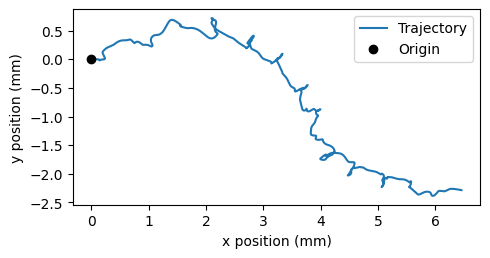

In [7]:
import matplotlib.pyplot as plt

with open(output_dir / "sim_data.pkl", "rb") as f:
    sim_data = pickle.load(f)

trajectory = np.array([obs["fly"][0, :2] for obs in sim_data["obs_hist"]])
fig, ax = plt.subplots(figsize=(5, 4), tight_layout=True)
ax.plot(trajectory[:, 0], trajectory[:, 1], label="Trajectory")
ax.plot([0], [0], "ko", label="Origin")
ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("x position (mm)")
ax.set_ylabel("y position (mm)")
fig.savefig(output_dir / "trajectory_sample_1s.png")

We can also plot the recorded shifts in leg tip positions relative to the fly's thorax:

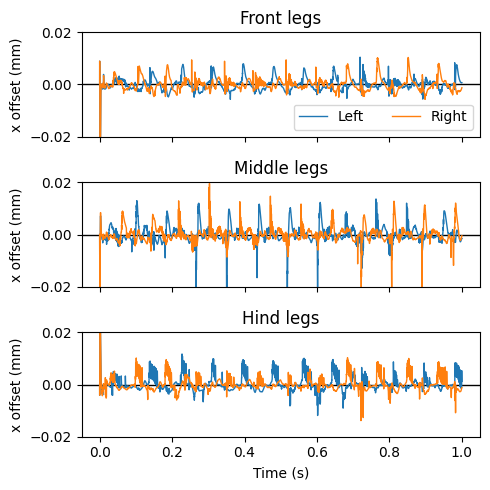

In [8]:
stride_diff_unmasked = np.array(
    [x["stride_diff_unmasked"] for x in sim_data["obs_hist"]]
)
t_grid = np.arange(stride_diff_unmasked.shape[0]) * 1e-4
fig, axs = plt.subplots(3, 1, figsize=(5, 5), tight_layout=True, sharex=True)
for i, leg_pair in enumerate(["Front", "Middle", "Hind"]):
    ax = axs[i]
    ax.axhline(0, color="k", linestyle="-", lw=1)
    left_ts = stride_diff_unmasked[:, i, :]
    right_ts = stride_diff_unmasked[:, i + 3, :]
    ax.plot(t_grid, left_ts[:, 0], lw=1, label="Left")
    ax.plot(t_grid, right_ts[:, 0], lw=1, label="Right")
    ax.set_ylim(-0.02, 0.02)
    if i == 0:
        ax.legend(ncols=2, loc="lower right")
    if i == 2:
        ax.set_xlabel("Time (s)")
    ax.set_ylabel("x offset (mm)")
    ax.set_title(f"{leg_pair} legs")
    fig.savefig(output_dir / "ee_shift_1s.png")

This plot shows the time series of the change in the x position (along the anterior-posterior axis) of the leg tips from the previous time step. Note that the values can be both positive and negative. This is because we are simply reporting the shift in the claw positions without taking into account whether the legs are in stance or swing yet.

In the NeuroMechFly v2 paper, we ran 15 trials with different random seeds for each of the three gaits: tripod gait, tetrapod gait, and wave gait. Each trial was 20 seconds long. In this tutorial, we will use only 5 trials for the tripod gait. We have uploaded the simulation data of all trials to a SFTP server. Instead of running these simulations yourself (which would take roughly 20 minutes on a machine with 5+ cores), you can simply download the data by running the following code block:

In [9]:
# TODO. We are working with our IT team to set up a gateway to share these data publicly
# in a secure manner. We aim to update this by the end of June, 2024. Please reach out
# to us by email in the meantime.

In [10]:
exploration_data_dir = (
    Path.home() / "Data/flygym_demo_data/path_integration/random_exploration/"
)
if not exploration_data_dir.is_dir():
    raise FileNotFoundError(
        "Pregenerated simulation data not found. Please download it from TODO."
    )
else:
    print(f"[OK] Pregenerated simulation data found. Ready to proceed.")

[OK] Pregenerated simulation data found. Ready to proceed.


## Extracting input and target variables from simulation data

Let's start by loading basic information — time series of end effector positions, ground contact forces, descending drives, fly orientation, and fly position — from the simulation data files.

In [11]:
import gc


def load_trial_data(trial_dir: Path) -> dict[str, np.ndarray]:
    """Load simulation data from trial.
    The difference between ``load_trial_data`` and ``extract_variables`` is
    that the former loads the raw data from the trial (i.e., physics
    simulation). The latter extracts variables from these raw data subject
    to additional parameters such as time scale. For each trial, we only
    call ``load_trial_data`` once, but we may call ``extract_variables``
    multiple times with different parameters.

    Parameters
    ----------
    trial_dir : Path
        Path to the directory containing the trial data saved in
        ``exploration.run_simulation``.

    Returns
    -------
    dict[str, np.ndarray]
        Dictionary containing the following keys, each mapping to a time
        series saved as a numpy array:
        * "end_effector_pos_diff": End effector positions.
        * "contact_force": Contact forces.
        * "dn_drive": DN drives.
        * "fly_orientation_xy": Fly orientation in the form of a unit vector
          on the xy plane.
        * "fly_orientation_angle": Fly orientation in the form of an angle
          in radians.
        * "fly_pos": Fly position.
    """
    with open(trial_dir / "sim_data.pkl", "rb") as f:
        sim_data = pickle.load(f)
    obs_hist = sim_data["obs_hist"]

    # End effector positions
    end_effector_pos_diff = np.array(
        [obs["stride_diff_unmasked"] for obs in obs_hist], dtype=np.float32
    )

    # Contact forces
    contact_force_ts = np.array(
        [obs["contact_forces"] for obs in obs_hist], dtype=np.float32
    )
    contact_force_ts = np.linalg.norm(contact_force_ts, axis=2)  # calc force magnitude
    contact_force_ts = contact_force_ts.reshape(-1, 6, 6).sum(axis=2)  # total per leg

    # Fly position
    fly_pos_ts = np.array([obs["fly"][0, :2] for obs in obs_hist], dtype=np.float32)

    # Heading
    fly_orientation_xy = np.array(
        [obs["fly_orientation"][:2] for obs in obs_hist], dtype=np.float32
    )
    fly_orientation_angle = np.arctan2(
        fly_orientation_xy[:, 1], fly_orientation_xy[:, 0]
    )

    # Clear RAM right away manually to avoid memory fragmentation
    del sim_data
    gc.collect()

    return {
        "end_effector_pos_diff": end_effector_pos_diff.astype(np.float32),
        "contact_force": contact_force_ts.astype(np.float32),
        "fly_orientation_xy": fly_orientation_xy.astype(np.float32),
        "fly_orientation_angle": fly_orientation_angle.astype(np.float32),
        "fly_pos": fly_pos_ts.astype(np.float32),
    }

In [12]:
trial_data = []
num_trials = 5
for seed in range(num_trials):
    print(f"Loading trial {seed + 1} of {num_trials}...")
    trial_dir = exploration_data_dir / f"seed={seed}_gait=tripod"
    data = load_trial_data(trial_dir)
    trial_data.append(data)

Loading trial 1 of 5...
Loading trial 2 of 5...
Loading trial 3 of 5...
Loading trial 4 of 5...
Loading trial 5 of 5...


In [13]:
trial_data[0].keys()

dict_keys(['end_effector_pos_diff', 'contact_force', 'fly_orientation_xy', 'fly_orientation_angle', 'fly_pos'])

We will perform some sanity tests on the data. As before, we can visualize the per-step change in end effector (leg tip) positions over 1 second of simulation, but this time in 2D:

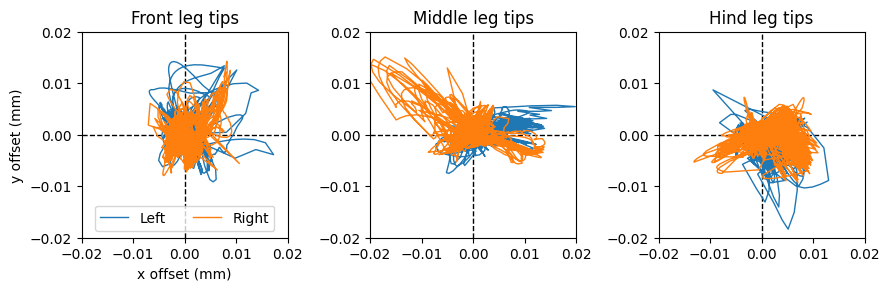

In [14]:
data = trial_data[0]
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
for i, leg_pair in enumerate(["Front", "Middle", "Hind"]):
    ax = axs[i]
    ax.axvline(0, color="k", linestyle="--", lw=1)
    ax.axhline(0, color="k", linestyle="--", lw=1)
    ax.plot(
        data["end_effector_pos_diff"][10000:20000, i, 0],
        data["end_effector_pos_diff"][10000:20000, i, 1],
        lw=1,
        label="Left",
    )
    ax.plot(
        data["end_effector_pos_diff"][10000:20000, i + 3, 0],
        data["end_effector_pos_diff"][10000:20000, i + 3, 1],
        lw=1,
        label="Right",
    )
    ax.set_aspect("equal")
    ax.set_xlim(-0.02, 0.02)
    ax.set_ylim(-0.02, 0.02)
    ax.set_title(f"{leg_pair} leg tips")
    if i == 0:
        ax.set_xlabel("x offset (mm)")
        ax.set_ylabel("y offset (mm)")
        ax.legend(ncols=2, loc="lower center")
fig.savefig(output_dir / "ee_shift_2d.png")

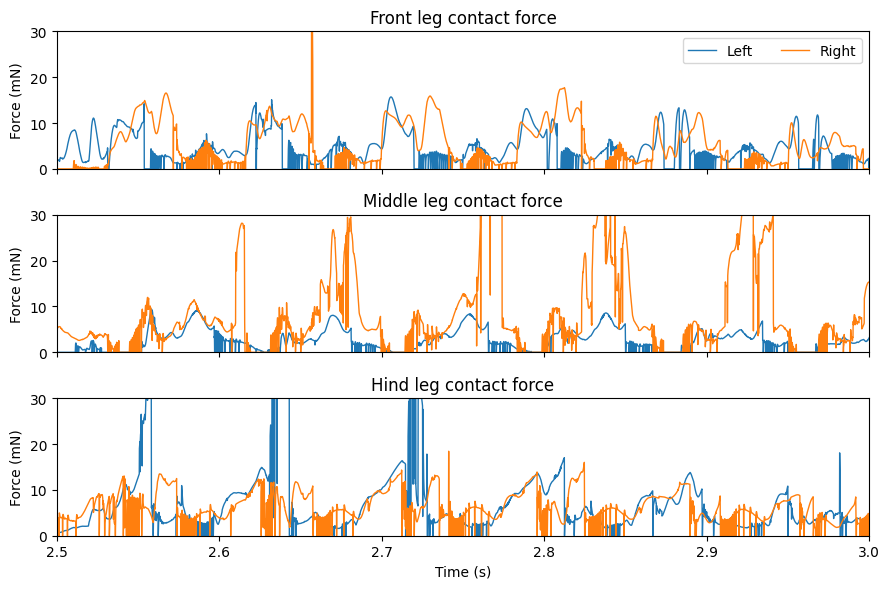

In [15]:
t_grid = np.arange(data["contact_force"].shape[0]) * 1e-4
fig, axs = plt.subplots(3, 1, figsize=(9, 6), tight_layout=True, sharex=True)
for i, leg_pair in enumerate(["Front", "Middle", "Hind"]):
    ax = axs[i]
    ax.plot(t_grid, data["contact_force"][:, i], lw=1, label="Left")
    ax.plot(t_grid, data["contact_force"][:, i + 3], lw=1, label="Right")
    ax.set_xlim(2.5, 3)
    ax.set_ylim(0, 30)
    ax.set_title(f"{leg_pair} leg contact force")
    ax.set_ylabel("Force (mN)")
    if i == 2:
        ax.set_xlabel("Time (s)")
    if i == 0:
        ax.legend(ncols=2, loc="upper right")
fig.savefig(output_dir / "ee_contact_force.png")

From the contact force time series, we can observe that:

1. There are roughly 6 groups of non-zero blocks per time series. These are the 6 stance phases per line over the period of 0.5 seconds (the CPG frequency is 12 Hz).
2. The two sides are not necessarily symmetrical. This is because the fly might turn during walking.
3. The hind leg has a lower signal-to-noise ratio than the front and middle legs.

Next, we will inspect the fly's orientation and position:

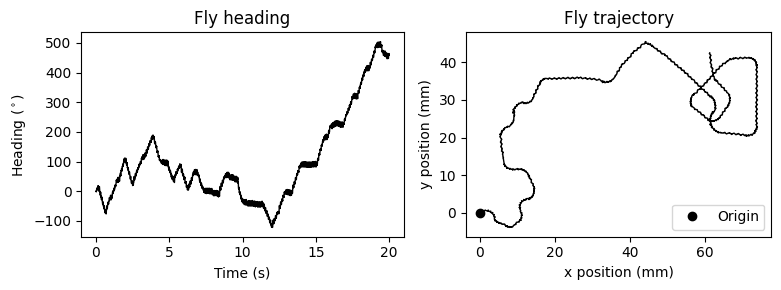

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

unwrapped_heading = np.unwrap(data["fly_orientation_angle"])
axs[0].plot(t_grid, np.rad2deg(unwrapped_heading), lw=1, color="k")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel(r"Heading ($^\circ$)")
axs[0].set_title("Fly heading")

axs[1].plot(data["fly_pos"][:, 0], data["fly_pos"][:, 1], lw=1, color="k")
axs[1].plot([0], [0], "ko", label="Origin")
axs[1].set_aspect("equal")
axs[1].set_xlabel("x position (mm)")
axs[1].set_ylabel("y position (mm)")
axs[1].legend(loc="lower right")
axs[1].set_title("Fly trajectory")

fig.savefig(output_dir / "heading_and_trajectory.png")

Recall the algorithm that we have proposed. To train the models, we need to collect the following _input_ variables to the model:

- Difference in the left-right _sum_ of cumulated stride lengths, `stride_total_diff_lrsum`
- Difference in the left-right _difference_ of cumulated stride lengths, `stride_total_diff_lrdiff`

... and the following _target_ variables (i.e., what the models are supposed to predict):

- Difference in the fly's heading, `heading_diff`
- Difference in the fly's total forward displacement, `forward_disp_total_diff`

There are two things to note here:

1. We have not implemented the calculation of stride lengths yet; `stride_diff_unmasked` is only the shift of the leg tip position from one time step to the next.
2. As discussed in the Algorithm section, the differences above are calculated over a predefined time scale $\tau$.

To calculate the cumulated stride lengths given `stride_diff_unmasked`, we need to mask it with a boolean time series indicating whether the leg is "pushing" (as opposed to swinging) before taking the cumulative sum. More precisely,

$$ 
\begin{gather*}
    \text{stride\_total}[0] = 0 \\
    \text{stride\_total}[i] = \text{stride\_total}[i - 1] +
        \big( \text{mask}[i] \cdot \text{ stride\_diff\_unmasked}[i] \big)
    \quad \text{for } i > 0
\end{gather*}
$$

where $\text{mask}[i]$ is a boolean indicating whether the leg is in the power stroke (push). In our example, we will use the ground contact force to determine if the leg is in contact with the floor. If it is, then the leg is executing a power stroke. We will use a threshold of 0.5 mN, 1 mN, and 3mN for the front, middle, and hind legs respectively.

Once we have the cumulative stride lengths for each leg, we can calculate how it changes over the predefined time scale $\tau$:

$$
\text{stride\_total\_diff}[i] =
    \text{stride\_total}[i] - \text{stride\_total}[i - \text{window\_len}]
$$

where $\text{window\_len} = \tau / \Delta t$ is the number of simulation steps over the time scale $\tau$.

With this, we can finally calculate the changes in the left-right sum and left-right difference of cumulative stride lengths for each leg pair over time:

$$
\begin{align*}
    \text{stride\_total\_diff\_lrsum}[i] &= 
        \text{stride\_total\_diff}_\text{left}[i] +
        \text{stride\_total\_diff}_\text{right}[i] \\
    \text{stride\_total\_diff\_lrdiff}[i] &= 
        \text{stride\_total\_diff}_\text{left}[i] -
        \text{stride\_total\_diff}_\text{right}[i] \\
\end{align*}
$$

Having extracted the _input_ variables, we will next extract the target _output_ variables: the changes in the fly's heading and forward displacement over the same time scale.

Calculating the change in the fly's heading is straightforward: for each simulation step $i$,
$$
\text{heading\_diff}[i] = \text{heading}[i] - \text{heading}[i - \text{window\_len}]
\quad \text{wrapped to $[-\pi, \pi)$}
$$
where $\text{heading}$ is the heading angle.

To calculate the change in the fly's forward displacement, we first have to accumulate the forward displacement from one step to the next over the whole simulation. We will call this variable $\text{forward\_disp}$. This sounds simply like the total travel distance, but the critical difference is that at the scale of single simulation steps, we discard lateral movements. Then, similar to the change in heading, we can simply calculate the cumulative forward displacement over the time period of $\tau$:

$$
\begin{gather*}
    \text{forward\_disp}[0] = 0, \\
    \text{forward\_disp}[i] =
        \text{forward\_disp}[i - 1] + \text{d\_forward\_disp}[i]
    \quad\text{for } i > 0
\end{gather*}
$$

where

$$
\text{d\_forward\_disp}[i] = (\overrightarrow{\text{position}}[i] -
        \overrightarrow{\text{position}}[i - 1]) \cdot
        \begin{bmatrix}
            \cos(\text{heading}[i])\\
            \sin(\text{heading}[i])
        \end{bmatrix}
$$

where $\overrightarrow{\text{position}}[i]$ is the fly's vector position (x-y) at simulation step $i$.

With this, the change in total forward displacement is:
$$
\text{forward\_disp\_diff}[i] =
    \text{forward\_disp}[i] -
    \text{forward\_disp}[i - \text{window\_len}]
$$

Let's implement a function that extracts these variables:

In [17]:
def extract_variables(
    trial_data: dict[str, np.ndarray],
    time_scale: float,
    contact_force_thr: tuple[float, float, float],
    dt: float = 1e-4,
) -> dict[str, np.ndarray]:
    """
    Extract variables used for path integration from trial data.
    The difference between ``load_trial_data`` and ``extract_variables`` is
    that the former loads the raw data from the trial (i.e., physics
    simulation). The latter extracts variables from these raw data subject
    to additional parameters such as time scale. For each trial, we only
    call ``load_trial_data`` once, but we may call ``extract_variables``
    multiple times with different parameters.

    Parameters
    ----------
    trial_data : dict[str, np.ndarray]
        Dictionary containing trial data.
    time_scale : float
        Time scale for path integration.
    contact_force_thr : tuple[float, float, float]
        Thresholds for contact forces. These are used to determine whether
        a leg is in contact with the ground.
    dt : float, optional
        Time step of the physics simulation in the trial, by default 1e-4.
    """
    window_len = int(time_scale / dt)
    # contact force thresholds: (3,) -> (6,), for both sides
    contact_force_thr = np.array([*contact_force_thr, *contact_force_thr])

    # Mechanosensory signal ==========
    # Calculate total stride (Σstride) for each side
    stride_left = trial_data["end_effector_pos_diff"][:, :3, 0]  # (L, 3)
    stride_right = trial_data["end_effector_pos_diff"][:, 3:, 0]  # (L, 3)
    contact_mask = trial_data["contact_force"] > contact_force_thr[None, :]  # (L, 6)
    stride_left = stride_left * contact_mask[:, :3]
    stride_right = stride_right * contact_mask[:, 3:]
    stride_total_left = np.cumsum(stride_left, axis=0)
    stride_total_right = np.cumsum(stride_right, axis=0)

    # Calculate difference in Σstride over proprioceptive time window (ΔΣstride)
    stride_total_diff_left = (
        stride_total_left[window_len:] - stride_total_left[:-window_len]
    )
    stride_total_diff_right = (
        stride_total_right[window_len:] - stride_total_right[:-window_len]
    )

    # Calculate sum and difference in ΔΣstride over two sides
    stride_total_diff_lrsum = stride_total_diff_left + stride_total_diff_right
    stride_total_diff_lrdiff = stride_total_diff_left - stride_total_diff_right

    # Change in locomotion state (heading & displacement) ==========
    # Calculate change in fly orientation over proprioceptive time window (Δheading)
    fly_orientation_xy = trial_data["fly_orientation_xy"]
    fly_orientation_angle = trial_data["fly_orientation_angle"]
    heading_diff = (
        fly_orientation_angle[window_len:] - fly_orientation_angle[:-window_len]
    )
    heading_diff = (heading_diff + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]

    # Same for displacement projected in the direction of fly's heading
    # Use projection formula: proj_v(u) = (u · v) / (v · v) * v where v is the fly's
    # heading vector and u is the change in position
    fly_disp_xy = np.diff(trial_data["fly_pos"], axis=0, prepend=0)
    fly_orientation_xy_norm = np.linalg.norm(fly_orientation_xy, axis=1)
    fly_orientation_xy_unit = fly_orientation_xy / fly_orientation_xy_norm[:, None]
    udotv = np.sum(fly_disp_xy * fly_orientation_xy_unit, axis=1)
    vdotv = np.sum(fly_orientation_xy_unit * fly_orientation_xy_unit, axis=1)
    forward_disp_mag = udotv / vdotv
    forward_disp_total = np.cumsum(forward_disp_mag)
    forward_disp_total_diff = (
        forward_disp_total[window_len:] - forward_disp_total[:-window_len]
    )

    return {
        "stride_total_diff_lrsum": stride_total_diff_lrsum.astype(np.float32),
        "stride_total_diff_lrdiff": stride_total_diff_lrdiff.astype(np.float32),
        "heading_diff": heading_diff.astype(np.float32),
        "forward_disp_total_diff": forward_disp_total_diff.astype(np.float32),
    }

Let's use this function to extract the input and target variables at a time scale of 0.32 s using a contact force threshold of 0.5 mN, 1 mN, and 3 mN for the front, middle, and hind legs respectively:

In [18]:
time_scale = 0.32
contact_force_thr = (0.5, 1, 3)
extracted_variables = [
    extract_variables(data, time_scale, contact_force_thr) for data in trial_data
]

We are trying to predict the change in forward displacement from the changes in left-right sums, and the change in heading from the left-right differences. Let's plot these variable in one trial to decide if these are qualitatively good predictors:

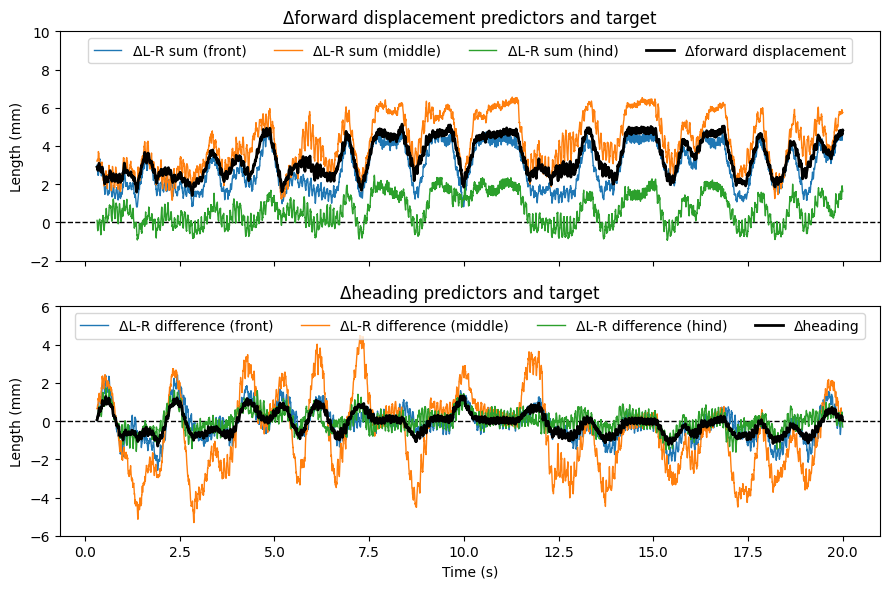

In [19]:
ext_vars = extracted_variables[0]
t_grid_trim = t_grid[-ext_vars["stride_total_diff_lrsum"].shape[0] :]
fig, axs = plt.subplots(2, 1, figsize=(9, 6), tight_layout=True, sharex=True)

axs[0].axhline(0, color="k", linestyle="--", lw=1)
for i, leg in enumerate(["Front", "Middle", "Hind"]):
    axs[0].plot(
        t_grid_trim,
        -ext_vars["stride_total_diff_lrsum"][:, i],
        lw=1,
        label=f"ΔL-R sum ({leg.lower()})",
    )
axs[0].plot(
    t_grid_trim,
    ext_vars["forward_disp_total_diff"],
    lw=2,
    color="k",
    label="Δforward displacement",
)
axs[0].legend(loc="upper center", ncol=4)
axs[0].set_ylabel("Length (mm)")
axs[0].set_ylim(-2, 10)
axs[0].set_title("Δforward displacement predictors and target")

axs[1].axhline(0, color="k", linestyle="--", lw=1)
for i, leg in enumerate(["Front", "Middle", "Hind"]):
    axs[1].plot(
        t_grid_trim,
        -ext_vars["stride_total_diff_lrdiff"][:, i],
        lw=1,
        label=f"ΔL-R difference ({leg.lower()})",
    )
axs[1].plot(
    t_grid_trim,
    -ext_vars["heading_diff"],
    lw=2,
    color="k",
    label="Δheading",
)
axs[1].legend(loc="upper center", ncol=4)
axs[1].set_ylabel("Length (mm)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylim(-6, 6)
axs[1].set_title("Δheading predictors and target")

fig.savefig(output_dir / "pathint_predictors_and_target.png")

We observe that the inputs (blue, orange, and green lines) indeed seem to be good predictors of the target (black lines). Next, we will train the prediction models based on our proposed algorithm.

## Training models to predict changes in locomotor state

Once the input and target variables have been extracted, training the models themselves is relatively easy. As discussed, we will train two linear models to predict the changes in forward displacement and heading using changes in the left-right sums and differences in cumulative stride lengths:
$$
\begin{align*}
    \text{heading\_diff\_pred}[i] &=
        \sum_{pos\in\{\text{front}, \text{middle}, \text{hind}\}}
            \big(
                k_{pos}^{({\rm h})} \cdot \text{stride\_total\_diff\_lrsum}_{pos}[i]
            \big) + b^{({\rm h})} \\
    \text{forward\_disp\_diff\_pred}[i] &=
        \sum_{pos\in\{\text{front}, \text{middle}, \text{hind}\}}
            \big(
                k_{pos}^{({\rm fd})} \cdot \text{stride\_total\_diff\_lrdiff}_{pos}[i]
            \big) + b^{({\rm fd})} \\
\end{align*}
$$
where $\text{heading\_diff\_pred}$ and $\text{forward\_disp\_diff\_pred}$ are the model's predictions of $\text{heading\_diff}$ and $\text{forward\_disp\_diff}$; $k_{pos}^{({\rm h})}$, $b^{({\rm h})}$, $k_{pos}^{({\rm fd})}$, and $b^{({\rm fd})}$ are the parameters to be fitted. While we are using all three pairs of legs in this example, a different set of legs can be used instead.

Recall that we have 5 trials per gait type. We will concatenate the first 4 trials to form the training set, and then use the last trial for testing.

In [20]:
stride_total_diff_lrsum_train = np.concatenate(
    [ext_vars["stride_total_diff_lrsum"] for ext_vars in extracted_variables[:4]]
)
stride_total_diff_lrdiff_train = np.concatenate(
    [ext_vars["stride_total_diff_lrdiff"] for ext_vars in extracted_variables[:4]]
)
heading_diff_train = np.concatenate(
    [ext_vars["heading_diff"] for ext_vars in extracted_variables[:4]]
)
forward_disp_total_diff_train = np.concatenate(
    [ext_vars["forward_disp_total_diff"] for ext_vars in extracted_variables[:4]]
)
stride_total_diff_lrsum_test = extracted_variables[4]["stride_total_diff_lrsum"]
stride_total_diff_lrdiff_test = extracted_variables[4]["stride_total_diff_lrdiff"]
heading_diff_test = extracted_variables[4]["heading_diff"]
forward_disp_total_diff_test = extracted_variables[4]["forward_disp_total_diff"]

Then, we will train the linear models using the `LinearRegression` class from scikit-learn.

In [21]:
from sklearn.linear_model import LinearRegression


def fit_1d_linear_model(x: np.ndarray, y: np.ndarray) -> tuple[LinearRegression, float]:
    model = LinearRegression()
    model.fit(x, y)
    r2 = model.score(x, y)
    return model, r2


heading_model, heading_model_r2 = fit_1d_linear_model(
    stride_total_diff_lrdiff_train, heading_diff_train
)
fwd_disp_model, fwd_disp_model_r2 = fit_1d_linear_model(
    stride_total_diff_lrsum_train, forward_disp_total_diff_train
)
print("Δheading model:")
print(f"  coefficients (front, middle, hind legs): {heading_model.coef_}")
print(f"  intercept: {heading_model.intercept_}")
print(f"  r2 score (training set): {heading_model_r2}")
print("Δforward displacement model:")
print(f"  coefficients (front, middle, hind legs): {fwd_disp_model.coef_}")
print(f"  intercept: {fwd_disp_model.intercept_}")
print(f"  r2 score (training set): {fwd_disp_model_r2}")

Δheading model:
  coefficients (front, middle, hind legs): [0.24994847 0.18084855 0.02075428]
  intercept: -0.006393308751285076
  r2 score (training set): 0.9610564708709717
Δforward displacement model:
  coefficients (front, middle, hind legs): [-0.5035825  -0.3369246   0.00302732]
  intercept: 0.49183177947998047
  r2 score (training set): 0.9717244505882263


## Integrating changes in locomotor state to estimate position

Now that we have built models that can estimate the changes in heading and forward displacement, we will integrate these changes to estimate the fly's location in space. To do this, we essentially reverse the process of extracting the change signals: whereas previously we have taken the per-step changes in cumulative stride lengths as an estimation of instantaneous changes, we will now sum these changes as an approximation of continuous integration.

More formally, from the model-predicted change in heading, $\text{heading\_diff\_pred}$, the estimated heading can be given by
$$
\text{heading\_pred}[i] =
    \sum_{i'=0}^i \frac{\text{heading\_diff\_pred}[i']}{\text{window\_len}}
$$
where, once again, $\text{window\_len} = \tau / \Delta t$ is the number of simulation steps over the time scale $\tau$.

To obtain the estimated position vector, $\overrightarrow{\text{position\_pred}}$, we have to take into account the fact that the change in _forward_ displacement must be integrated in the direction of the fly's instantaneous heading:
$$
\overrightarrow{\text{position\_pred}}[i] =
    \sum_{i'=0}^i \frac{\text{fwd\_disp\_diff\_pred}[i']}{\text{window\_len}}
    \begin{bmatrix}
        \cos(\text{heading\_pred}[i'])\\
        \sin(\text{heading\_pred}[i'])
    \end{bmatrix}
$$

We will now implement this integration logic:

In [22]:
from typing import Callable


def path_integrate(
    trial_data: dict[str, np.ndarray],
    heading_model: Callable,
    displacement_model: Callable,
    time_scale: float,
    contact_force_thr: tuple[float, float, float],
    dt: float = 1e-4,
):
    """
    Perform path integration on trial data.

    Parameters
    ----------
    trial_data : dict[str, np.ndarray]
        Dictionary containing trial data.
    heading_model : Callable
        Model for predicting change in heading.
    displacement_model : Callable
        Model for predicting change in displacement.
    time_scale : float
        Time scale for path integration.
    contact_force_thr : tuple[float, float, float]
        Thresholds for contact forces. These are used to determine whether
        a leg is in contact with the ground.
    dt : float
        Time step of the physics simulation in the trial.

    Returns
    -------
    dict[str, np.ndarray]
        Dictionary containing the following keys:
        * "heading_pred": Predicted heading.
        * "heading_actual": Actual heading.
        * "pos_pred": Predicted position.
        * "pos_actual": Actual position.
        * "heading_diff_pred": Predicted change in heading.
        * "heading_diff_actual": Actual change in heading.
        * "displacement_diff_pred": Predicted change in displacement.
        * "displacement_diff_actual": Actual change in displacement.
    """
    window_len = int(time_scale / dt)
    variables = extract_variables(
        trial_data, time_scale=time_scale, contact_force_thr=contact_force_thr, dt=dt
    )

    # Integrate heading
    heading_diff_pred = heading_model(variables["stride_total_diff_lrdiff"])
    heading_pred = np.cumsum(heading_diff_pred / window_len)
    # Path int. not performed when not enough data is available. Start from the real
    # heading at the moment when path int. actually starts.
    hx_start, hy_start = trial_data["fly_orientation_xy"][window_len, :]
    real_heading_start = np.arctan2(hy_start, hx_start)
    heading_pred += real_heading_start

    # Integrate displacement
    displacement_diff_pred = displacement_model(variables["stride_total_diff_lrsum"])
    displacement_diff_x_pred = np.cos(heading_pred) * displacement_diff_pred
    displacement_diff_y_pred = np.sin(heading_pred) * displacement_diff_pred
    pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
    pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
    pos_x_pred += trial_data["fly_pos"][window_len, 0]
    pos_y_pred += trial_data["fly_pos"][window_len, 1]
    pos_pred = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

    # Pad with NaN where prediction not available
    padding = np.full(window_len, np.nan)
    heading_pred = np.concatenate([padding, heading_pred])
    pos_pred = np.concatenate([np.full((window_len, 2), np.nan), pos_pred], axis=0)
    heading_diff_pred = np.concatenate([padding, heading_diff_pred])
    heading_diff_actual = np.concatenate([padding, variables["heading_diff"]])
    displacement_diff_pred = np.concatenate([padding, displacement_diff_pred])
    displacement_diff_actual = np.concatenate(
        [padding, variables["forward_disp_total_diff"]]
    )

    return {
        "heading_pred": heading_pred,
        "heading_actual": trial_data["fly_orientation_angle"],
        "pos_pred": pos_pred,
        "pos_actual": trial_data["fly_pos"],
        "heading_diff_pred": heading_diff_pred,
        "heading_diff_actual": heading_diff_actual,
        "displacement_diff_pred": displacement_diff_pred,
        "displacement_diff_actual": displacement_diff_actual,
    }

We can run this function on the last trial, which has been reserved for testing:

In [23]:
path_integration_res = path_integrate(
    trial_data[4],
    heading_model.predict,  # this is LinearRegression's method for making prediction
    fwd_disp_model.predict,  # "
    time_scale,
    contact_force_thr,
)

... and inspect the time series of predicted vs. actual changes in heading and forward displacement on this test dataset.

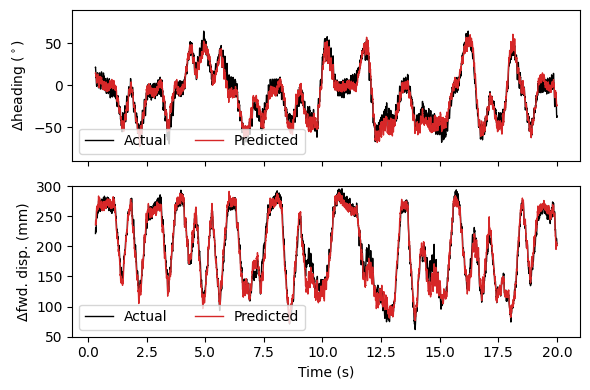

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True, sharex=True)

axs[0].plot(
    t_grid,
    np.rad2deg(path_integration_res["heading_diff_actual"]),
    lw=1,
    color="black",
    label="Actual",
)
axs[0].plot(
    t_grid,
    np.rad2deg(path_integration_res["heading_diff_pred"]),
    lw=1,
    color="tab:red",
    label="Predicted",
)
axs[0].set_ylabel(r"Δheading ($^\circ$)")
axs[0].set_ylim(-90, 90)
axs[0].legend(loc="lower left", ncols=2)

axs[1].plot(
    t_grid,
    np.rad2deg(path_integration_res["displacement_diff_actual"]),
    lw=1,
    color="black",
    label="Actual",
)
axs[1].plot(
    t_grid,
    np.rad2deg(path_integration_res["displacement_diff_pred"]),
    lw=1,
    color="tab:red",
    label="Predicted",
)
axs[1].set_ylabel("Δfwd. disp. (mm)")
axs[1].set_ylim(50, 300)
axs[1].legend(loc="lower left", ncols=2)
axs[1].set_xlabel("Time (s)")
fig.savefig(output_dir / "path_integration_diff.png")

Similarly, we can plot the integrated estimation of heading and total forward displacement:

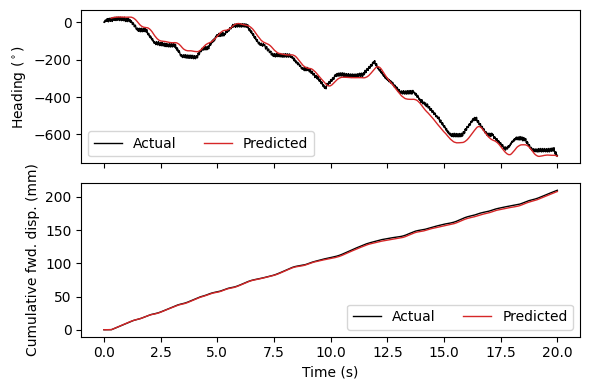

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True, sharex=True)

axs[0].plot(
    t_grid,
    np.rad2deg(np.unwrap(path_integration_res["heading_actual"])),
    lw=1,
    color="black",
    label="Actual",
)
axs[0].plot(
    t_grid,
    np.rad2deg(path_integration_res["heading_pred"]),
    lw=1,
    color="tab:red",
    label="Predicted",
)
axs[0].set_ylabel(r"Heading ($^\circ$)")
axs[0].legend(loc="lower left", ncols=2)

fwd_disp_total_actual = np.cumsum(
    np.nan_to_num(path_integration_res["displacement_diff_actual"])
) / (time_scale / 1e-4)
fwd_disp_total_pred = np.cumsum(
    np.nan_to_num(path_integration_res["displacement_diff_pred"])
) / (time_scale / 1e-4)
axs[1].plot(
    t_grid,
    fwd_disp_total_actual,
    lw=1,
    color="black",
    label="Actual",
)
axs[1].plot(
    t_grid,
    fwd_disp_total_pred,
    lw=1,
    color="tab:red",
    label="Predicted",
)
axs[1].set_ylabel("Cumulative fwd. disp. (mm)")
axs[1].legend(loc="lower right", ncols=2)
axs[1].set_xlabel("Time (s)")

fig.savefig(output_dir / "path_integration_cumulative.png")

Finally, we can plot the estimated and true trajectories of the fly:

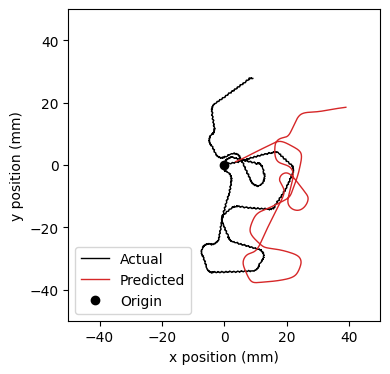

In [26]:
fig, ax = plt.subplots(figsize=(4, 4), tight_layout=True)

ax.plot(
    path_integration_res["pos_actual"][:, 0],
    path_integration_res["pos_actual"][:, 1],
    lw=1,
    color="black",
    label="Actual",
)
ax.plot(
    path_integration_res["pos_pred"][:, 0],
    path_integration_res["pos_pred"][:, 1],
    lw=1,
    color="tab:red",
    label="Predicted",
)
ax.plot([0], [0], "ko", label="Origin")
ax.set_aspect("equal")
ax.set_xlabel("x position (mm)")
ax.set_ylabel("y position (mm)")
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.legend(loc="lower left")
fig.savefig(output_dir / "path_integration_trajectory.png")

We can observe that, although the model gives excellent predictions in heading and forward displacement, small errors in heading can lead to larger errors in the final position estimation. This is simply due to the fact that walking straight in a slightly wrong direction amplifies the error in the estimated position. Therefore, while path integration based solely on idiothetic cues is possible, calibration of the integrator based on sensory inputs appears to be critical.